# Machine Learning Pipeline Case Study
本節使用Figure Eight Platform 提供的 Corporate Messaging Case Study 做為例子，我們首先把 NLP 前兩個 stage 處理好。

## Clean and Tokenize
在做任何分類之前，必須處理文字檔案，我們可以寫一個`tokenize`函式來幫忙，其功能如下
1. 找出文字中的網址，將其替換成`"urlplaceholder"`
2. 把文章轉成 token
3. 把每個 token lemmatize, normalize case, and strip leading and trailing white space
4. 回傳 list of tokens

In [1]:
# download necessary NLTK data
import nltk
nltk.download(['punkt', 'wordnet'])

# import statements
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ChihYing\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ChihYing\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def load_data():
    df = pd.read_csv('corporate_messaging.csv', encoding='latin-1')
    df = df[(df["category:confidence"] == 1) & (df['category'] != 'Exclude')]
    X = df.text.values
    y = df.category.values
    return X, y

In [3]:
url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

In [4]:
def tokenize(text):
    # get list of all urls using regex
    detected_urls = re.findall(url_regex, text)
    
    # replace each url in text string with placeholder
    for url in detected_urls:
        text = re.sub(url, "urlplaceholder", text)

    # tokenize text
    tokens = word_tokenize(text)
    
    # initiate lemmatizer
    lemmatizer = WordNetLemmatizer()

    # iterate through each token
    clean_tokens = []
    for tok in tokens:
        
        # lemmatize, normalize case, and remove leading/trailing white space
        clean_tok = WordNetLemmatizer().lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

In [5]:
# test out function
X, y = load_data()
for message in X[:5]:
    tokens = tokenize(message)
    print(message)
    print(tokens, '\n')

Barclays CEO stresses the importance of regulatory and cultural reform in financial services at Brussels conference  http://t.co/Ge9Lp7hpyG
['barclays', 'ceo', 'stress', 'the', 'importance', 'of', 'regulatory', 'and', 'cultural', 'reform', 'in', 'financial', 'service', 'at', 'brussels', 'conference', 'urlplaceholder'] 

Barclays announces result of Rights Issue http://t.co/LbIqqh3wwG
['barclays', 'announces', 'result', 'of', 'rights', 'issue', 'urlplaceholder'] 

Barclays publishes its prospectus for its å£5.8bn Rights Issue: http://t.co/YZk24iE8G6
['barclays', 'publishes', 'it', 'prospectus', 'for', 'it', 'å£5.8bn', 'rights', 'issue', ':', 'urlplaceholder'] 

Barclays Group Finance Director Chris Lucas is to step down at the end of the week due to ill health http://t.co/nkuHoAfnSD
['barclays', 'group', 'finance', 'director', 'chris', 'lucas', 'is', 'to', 'step', 'down', 'at', 'the', 'end', 'of', 'the', 'week', 'due', 'to', 'ill', 'health', 'urlplaceholder'] 

Barclays announces that I

## Machine Learning Workflow

通常會先個別確認程式能正確執行，最後才重新寫成函式。

### Step 1: Load data and perform a train test split

In [6]:
# import other library
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
# load data
X, y = load_data()

# perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Step 2: Train classifier
* Fit and transform the training data with `CountVectorizer`. 
* Fit and transform these word counts with `TfidfTransformer`.
* Fit a classifier to these tfidf values.

In [8]:
# Instantiate transformers and classifier
vect = CountVectorizer(tokenizer=tokenize)
tfidf = TfidfTransformer()
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit and/or transform each to the data
X_train_vect = vect.fit_transform(X_train)
X_train_tfidf = tfidf.fit_transform(X_train_vect)
clf.fit(X_train_tfidf, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

### Step 3: Predict on test data
* Transform (no fitting) the test data with the same CountVectorizer and TfidfTransformer
* Predict labels on these tfidf values.

In [9]:
# Transform test data
X_test_vect = vect.transform(X_test)
X_test_tfidf = tfidf.transform(X_test_vect)

# Predict test labels
y_pred = clf.predict(X_test_tfidf)

### Step 4: Display results
Display a confusion matrix and accuracy score based on the model's predictions.

In [10]:
labels = np.unique(y_test)
confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
accuracy = accuracy_score(y_test, y_pred)

print("Labels:", labels)
print("Confusion Matrix:\n", confusion_mat)
print("Accuracy:", accuracy)

Labels: ['Action' 'Dialogue' 'Information']
Confusion Matrix:
 [[ 66   0  13]
 [  0  29   7]
 [  4   0 362]]
Accuracy: 0.9501039501039501


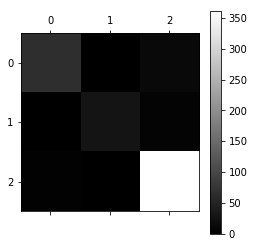

In [11]:
plt.matshow(confusion_mat, cmap=plt.cm.gray)
plt.colorbar();

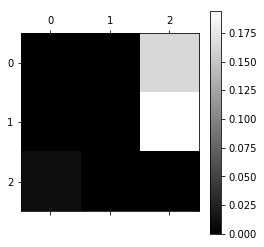

In [12]:
row_sums = confusion_mat.sum(axis=1, keepdims=True)
norm_conf_mx = confusion_mat / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.colorbar()
plt.show()

### Final Step: Refactor
Organize these steps into the following functions.

In [13]:
def display_results(y_test, y_pred):
    labels = np.unique(y_test)
    confusion_mat = confusion_matrix(y_test, y_pred, labels=labels)
    accuracy = accuracy_score(y_test, y_pred)

    print("Labels:", labels)
    print("Confusion Matrix:\n", confusion_mat)
    print("Accuracy:", accuracy)


def main():
    # load data
    X, y = load_data()

    # perform train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
    
    # Instantiate transformers and classifier
    vect = CountVectorizer(tokenizer=tokenize)
    tfidf = TfidfTransformer()
    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    # Fit and/or transform each to the data
    X_train_vect = vect.fit_transform(X_train)
    X_train_tfidf = tfidf.fit_transform(X_train_vect)
    clf.fit(X_train_tfidf, y_train)
    
    # Transform test data
    X_test_vect = vect.transform(X_test)
    X_test_tfidf = tfidf.transform(X_test_vect)

    # Predict test labels
    y_pred = clf.predict(X_test_tfidf)
    
    display_results(y_test, y_pred)

In [14]:
# run program
main()

Labels: ['Action' 'Dialogue' 'Information']
Confusion Matrix:
 [[ 66   0  13]
 [  0  29   7]
 [  4   0 362]]
Accuracy: 0.9501039501039501


## Build Pipeline

In [15]:
from sklearn.pipeline import Pipeline
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

    # build pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', RandomForestClassifier(random_state=42, n_estimators=100))
    ])
        
    # train classifier
    pipeline.fit(X_train, y_train)

    # predict on test data
    y_pred = pipeline.predict(X_test)
    
    # display results
    display_results(y_test, y_pred)

In [16]:
main()

Labels: ['Action' 'Dialogue' 'Information']
Confusion Matrix:
 [[ 66   0  13]
 [  0  29   7]
 [  4   0 362]]
Accuracy: 0.9501039501039501


## Pipelines and Feature Unions

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [18]:
from sklearn.pipeline import FeatureUnion
def model_pipeline():
    pipeline = Pipeline([
        ('feature', FeatureUnion([
            ('nlp_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
            
            ('starting_verb', StartingVerbExtractor())
        ])),
        
        ('clf', RandomForestClassifier(random_state=42, n_estimators=100))
        
    ])
    return pipeline

In [19]:
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = model_pipeline()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    display_results(y_test, y_pred)

main()

Labels: ['Action' 'Dialogue' 'Information']
Confusion Matrix:
 [[ 96   0  23]
 [  1  26   4]
 [  2   0 449]]
Accuracy: 0.9500831946755408


## Create Custom Transformer

In [20]:
from nltk.tokenize import sent_tokenize
from nltk.tag import pos_tag

class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        # tokenize by sentences
        sentence_list = sent_tokenize(text)
        
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            pos_tags = pos_tag(tokenize(sentence))

            # index pos_tags to get the first word and part of speech tag
            first_word, first_tag = pos_tags[0]
            
            # return true if the first word is an appropriate verb or RT for retweet
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
            return False

    def fit(self, x, y=None):
        return self

    def transform(self, X):
        # apply starting_verb function to all values in X
        X_tagged = pd.Series(X).apply(self.starting_verb)

        return pd.DataFrame(X_tagged)

In [21]:
def model_pipeline():
    pipeline = Pipeline([
        ('feature', FeatureUnion([
            ('nlp_pipeline', Pipeline([
                ('vect', CountVectorizer(tokenizer=tokenize)),
                ('tfidf', TfidfTransformer())
            ])),
            
            ('starting_verb', StartingVerbExtractor())
        ])),
        
        ('clf', RandomForestClassifier(random_state=42, n_estimators=100))
        
    ])
    return pipeline

In [22]:
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    model = model_pipeline()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    display_results(y_test, y_pred)

main()

Labels: ['Action' 'Dialogue' 'Information']
Confusion Matrix:
 [[ 88   0  31]
 [  0  35   4]
 [  3   1 439]]
Accuracy: 0.9351081530782029
